<a href="https://colab.research.google.com/github/akatukam/Random-Forest-Movie-Predictions/blob/main/RandomForestMoviePredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For the following project, you will be working with a movie dataset. The dataset is [here](https://drive.google.com/file/d/1R53inu8Jcb9GGoyiuVnBMVnO7XvCaJAE/view?usp=drive_link). The dataset columns are as follows:

* Title: The movie's title
* Genre: The movie's genre
* Stars: The number of famous actors in the movie
* Runtime: The length of the movie's runtime
* Budget: How much was spent on filming the movie (in millions)
* Promo: How much money was spent promoting the movie (in millions)
* Season: The season in which the movie was released
* Rating: The movie's rating
* R1: Reviewer 1's review
* R1: Reviewer 2's review
* R1: Reviewer 3's review

And the target variable:

* Success: Whether the film was a success or a flop

Fill in the answers to questions in the text field, and show your code below.

# Data loading

Load the data

In [ ]:
import pandas as pd
import sklearn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
!pip install textblob
from textblob import TextBlob
from google.colab import drive
drive.mount('/content/drive')
reviews = pd.read_csv('/content/drive/My Drive/CMSC320FinalProjectData.csv')

Mounted at /content/drive


# Data Cleaning

List the three biggest data errors below, with a summary of how you fixed them and why you choose that method:


* The runtime for some of the movies is 0, which seems to be some kind of error. Upon looking at a histogram of the frequency of different numbers of stars in movies, I opted to use mean imputation to fix the values. The data looks extremely normal other than the spike at 0, meaning that the mean would be a very likely value for the missing fields.

* The budget for some movies seems ridiculously high and unrealistic. Upon observation, it was clear that the decimals were misplaced. To identify which movies this was the case for, I calculated the z-scores of all the movies and adjusted my z-score range until only unreasonably budgeted movies were singled out. For these movies, I moved the decimal point to the left until they were in the range of the non-outlier movies' budgets. There was only one case of ambiguity here in terms of how far to move the decimal while keeping it in the range, which was easily deducable by manually looking at it's promo field and realizing it was most likely a small budget movie, and not one of the largest budget movies in the dataset, which would have been the alternative.

* The number of stars for some of the movies is 100, which seems to be an impossible amount. This is likely some kind of error. Since I have 541 movies worth of data, and this error only affects 2 of these movies, I opted to simply drop those two movies from my dataset. These movies represent far less than 1 percent of my data, so this felt like a valid way to go about fixing this issue.

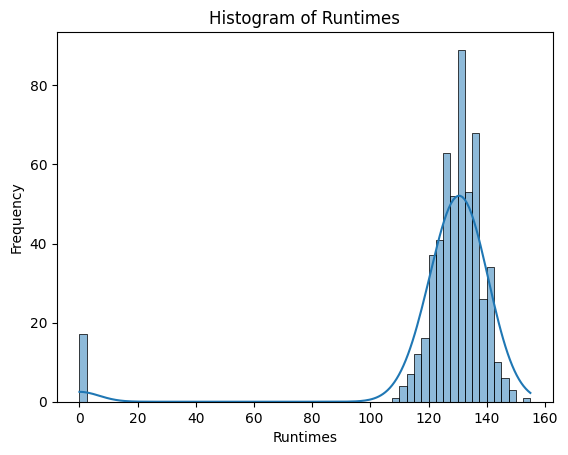

Mean: 126.08888888888889
Mode: 0    133
Name: Runtime, dtype: int64
Z-scores and Budget values for outliers:
     Budget_Zscores        Budget
0          3.230208  6.679387e+07
9          4.662378  9.464885e+07
21         5.373270  1.084753e+08
30         3.556415  7.313843e+07
32         1.350737  3.023914e+07
34         3.692512  7.578546e+07
46         1.518055  3.349339e+07
83         5.144428  1.040245e+08
97         7.261909  1.452084e+08
114        8.065695  1.608416e+08
130        4.804427  9.741162e+07
180        5.991392  1.204975e+08
227        3.014196  6.259256e+07
256        3.085582  6.398098e+07
320        4.199458  8.564528e+07
382        2.764466  5.773544e+07
401        4.980751  1.008410e+08
420        3.317407  6.848986e+07
451        2.743266  5.732310e+07
472        5.472595  1.104071e+08
478        2.960931  6.155658e+07
503        7.447894  1.488257e+08
514        5.340196  1.078320e+08
516        2.504662  5.268239e+07
526        2.583266  5.421120e+07
Range o

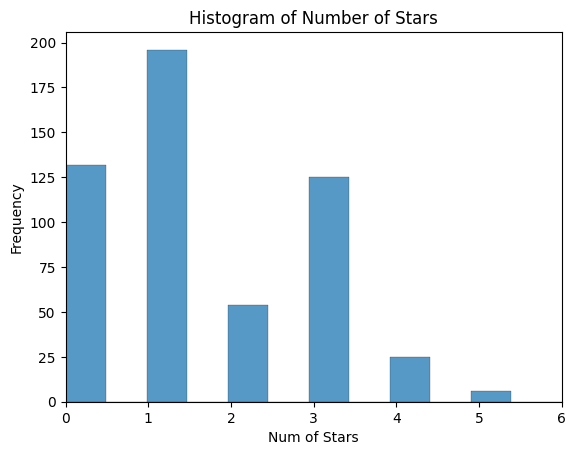

Mean: 1.8685185185185185
Mode: 0    1
Name: Stars, dtype: int64


In [ ]:
# Error # 1: Runtimes
########################

# Analyzing the frequency of various runtimes to decide what method to use
sns.histplot(reviews['Runtime'], kde = True)
plt.title('Histogram of Runtimes')
plt.xlabel('Runtimes')
plt.ylabel('Frequency')
plt.show()
print("Mean:", reviews['Runtime'].mean())
print("Mode:", reviews['Runtime'].mode())

# Using mean imputation
ave_runtime = reviews[reviews['Runtime'] != 0]['Runtime'].mean()
reviews.loc[reviews['Runtime'] == 0, 'Runtime'] = ave_runtime

# Error # 2: Budget
########################

# Identifying the outliers using their Z-scores """
reviews['Budget_Zscores'] = abs((reviews['Budget'] - reviews['Budget'].mean()) / reviews['Budget'].std())

# Adjusting this Z-score treshhold based on if the new budget range appears reasonable
# (When the Z-score was 0.1 higher, it included a movie with a budget of 30239136.298022225.
# As such, I stuck with 1.3, which has the next biggest value of 327, which appears reasonable)
threshold = 1.3
outliers = reviews[reviews['Budget_Zscores'] > threshold]
print("Z-scores and Budget values for outliers:")
print(outliers[['Budget_Zscores', 'Budget']])
budgets_without_outliers = reviews[reviews['Budget_Zscores'] <= threshold]['Budget']

# Print the range of budgets excluding outliers to check if the outlier threshhold is accurate
print("Range of valid budgets without outliers:", (budgets_without_outliers.min(), budgets_without_outliers.max()))
# Moving the decimal point to get the outlier budget in the range
scale = 1
scaled_outliers = outliers['Budget'].copy()
while any(scaled_outliers < budgets_without_outliers.min()) or any(scaled_outliers > budgets_without_outliers.max()):
    scaled_outliers = outliers['Budget'] / (10 ** scale)
    scale += 1
print("Fixed outliers:")
print(scaled_outliers)
reviews.loc[outliers.index, 'Budget'] = scaled_outliers
reviews.drop(columns=['Budget_Zscores'], inplace=True)

# Error # 3: Number of Stars
########################

# Analyzing the frequency of various numbers of stars
sns.histplot(reviews['Stars'])
plt.title('Histogram of Number of Stars')
plt.xlabel('Num of Stars')
plt.ylabel('Frequency')
plt.xlim(0, 6)
plt.show()
print("Mean:", reviews['Stars'].mean())
print("Mode:", reviews['Stars'].mode())
reviews = reviews[reviews['Stars'] != 100]

# Data Exploration





Does Season have a stastically significant impact on a movie's success?

Yes, it does. I performed a Chi-squared test of independence in which my null hypothesis was that seasons and movie success are independent, and my alternative hypothesis was that seasons and movie success are dependent. Since my p-value is so low—close to zero, my null hypothesis is not supported. Seasons do have a statistically significant impact on a movie's success.

**p-value:** 0.006534648782285328

In [ ]:
contingency_table = pd.crosstab(reviews['Season'], reviews['Success'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(p)

0.006534648782285328


Do seasons have a statistically significant difference in their distribution of content ratings?

No, they do not. I performed a Chi-squared test of independence in which my null hypothesis was that seasons and their distribution of content ratings are independent, and my alternative hypothesis was that seasons and their distribution of content ratings are dependent. Since my p-value is far over 0.05, my null hypothesis is significantly supported. Seasons do not have a statistically significant difference in their distribution of content ratings.

**p-value:** 0.2096305929818337

In [ ]:
contingency_table = pd.crosstab(reviews['Season'], reviews['Rating'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(p)

0.2096305929818337


Who is the harshest critic (highest precent of negative reviews)?

**Critic:** R1 is the harshest critic.

In [ ]:
reviews['Rev_R1'] = reviews['R1'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
reviews['Rev_R2'] = reviews['R2'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
reviews['Rev_R3'] = reviews['R3'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

def is_neg(sentiment_score):
    return 1 if sentiment_score < 0 else 0

reviews['Neg_R1'] = reviews['Rev_R1'].apply(is_neg)
reviews['Neg_R2'] = reviews['Rev_R2'].apply(is_neg)
reviews['Neg_R3'] = reviews['Rev_R3'].apply(is_neg)

print((reviews['Neg_R1'].sum() / len(reviews)) * 100)
print((reviews['Neg_R2'].sum() / len(reviews)) * 100)
print((reviews['Neg_R3'].sum() / len(reviews)) * 100)

reviews.drop(['Rev_R1', 'Rev_R2', 'Rev_R3',
              'Neg_R1', 'Neg_R2', 'Neg_R3'], axis=1, inplace=True)

54.646840148698885
43.30855018587361
34.94423791821561


What is the covariance between promotional budget and the filming budget?

**Cov:** 1908.7277141886009

In [ ]:
covariance = reviews['Promo'].cov(reviews['Budget'])
print(covariance)

1908.7277141886009


# Data Visualization

Create a chart that compares the distribution of the budget for each different number of stars. (It does not need to be particularly appealing.

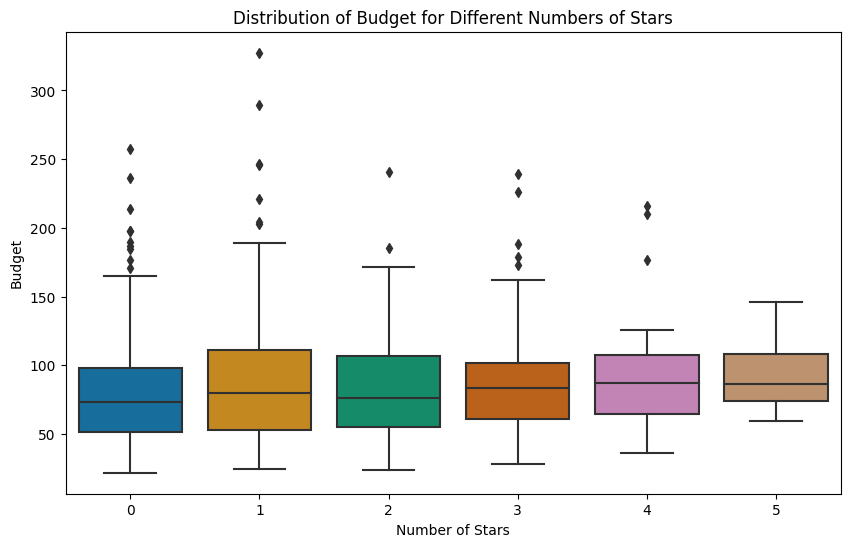

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Stars', y='Budget', data=reviews, palette='colorblind')
plt.xlabel('Number of Stars')
plt.ylabel('Budget')
plt.title('Distribution of Budget for Different Numbers of Stars')
plt.show()

Create a graph showing the average movie budget over time.

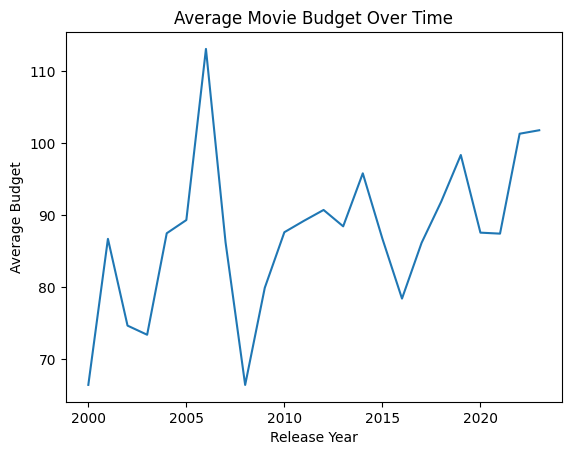

In [ ]:
avg_budget = reviews.groupby('Year')['Budget'].mean().reset_index()
sns.lineplot(x='Year', y='Budget', data=avg_budget)
plt.xlabel('Release Year')
plt.ylabel('Average Budget')
plt.title('Average Movie Budget Over Time')
plt.show()

# Feature Engineering

List any features you choose to create (if you are creating many features based on one column, you do not need to list them separately.) You are not required to create any features if you do not wish to. You may create any number of additional features.


* Season
* Rating
* Genre
* Polarity of R1
* Polarity of R2
* Polarity of R3
* Sentiment of R1
* Sentiment of R2
* Sentiment of R3

In [ ]:
reviews['R1_Polarity'] = reviews['R1'].apply(lambda text: TextBlob(str(text)).sentiment.polarity)
reviews['R1_Subjectivity'] = reviews['R1'].apply(lambda text: TextBlob(str(text)).sentiment.subjectivity)

reviews['R2_Polarity'] = reviews['R2'].apply(lambda text: TextBlob(str(text)).sentiment.polarity)
reviews['R2_Subjectivity'] = reviews['R2'].apply(lambda text: TextBlob(str(text)).sentiment.subjectivity)

reviews['R3_Polarity'] = reviews['R3'].apply(lambda text: TextBlob(str(text)).sentiment.polarity)
reviews['R3_Subjectivity'] = reviews['R3'].apply(lambda text: TextBlob(str(text)).sentiment.subjectivity)

numerical_cols = ['Budget', 'Promo', 'Stars']
categorical_cols = ['Rating', 'Season', 'Genre']
sentiment_cols = ['R1_Polarity', 'R1_Subjectivity', 'R2_Polarity', 'R2_Subjectivity', 'R3_Polarity', 'R3_Subjectivity']

encoded_categorical_cols = pd.get_dummies(reviews[categorical_cols])
feature_matrix = pd.concat([reviews[numerical_cols + sentiment_cols], encoded_categorical_cols], axis=1)

# Modeling

Create a model of your choice.

**Model type choosen:** Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = feature_matrix
y = reviews['Success']

rf_classifier = RandomForestClassifier(n_estimators=100, class_weight = 'balanced', max_depth=13, random_state=0)

# Testing

Shuffle your data and break it into a 10% test set and 90% training set. Show your model's accuracy on the test set. In order to get full credit, the model's accuracy must be higher than 50%.

**Model accuracy:** 0.83

In [ ]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: ", accuracy)

Accuracy:  0.8333333333333334


Show the confusion matrix for your model. To get full credit, your false positive rate and false negative rate must be under 30%.


**False negative rate:** 0.13

**False positive rate:** 0.04

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

fpr = fp/(fp+tp+fn+tn)
fnr = fn/(fp+tp+fn+tn)

print("Confusion Matrix:")
print(conf_matrix)

print(f"False Positive Rate:", fpr)
print(f"False Negative Rate:", fnr)

Confusion Matrix:
[[42  2]
 [ 7  3]]
False Positive Rate: 0.037037037037037035
False Negative Rate: 0.12962962962962962


What was the most important feature for your model? Don't guess, either look up how to check or do your own tests.

**Most important feature:** The polarity of reviewer 1's reviews


In [ ]:
importance = rf_classifier.feature_importances_
scores = pd.Series(importance, index=X.columns)
print(scores)

Budget                   0.118188
Promo                    0.112403
Stars                    0.094441
R1_Polarity              0.179715
R1_Subjectivity          0.076461
R2_Polarity              0.069949
R2_Subjectivity          0.063839
R3_Polarity              0.060805
R3_Subjectivity          0.058472
Rating_PG                0.014420
Rating_PG13              0.012935
Rating_R                 0.017719
Season_Fall              0.008465
Season_Spring            0.017420
Season_Summer            0.012976
Season_Winter            0.013207
Genre_Action             0.031177
Genre_Drama              0.012175
Genre_Fantasy            0.005535
Genre_Romantic Comedy    0.015634
Genre_Science fiction    0.004065
dtype: float64
